<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/VAE_origin_Exp01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again
* Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum -> mean
* Add 
    * train, test loss plot
    * save model's state dict

* Reference repository: https://github.com/pytorch/examples/tree/master/vae

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Drive Mount

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [4]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
# transforms module 사용해서 Image data compose
# ImageFolder를 사용해 dataload

transforms = transforms.Compose([
                                 transforms.Resize((224, 224)),
                                 transforms.Grayscale(num_output_channels=1),  # make Image to 1-dim channel
                                 transforms.ToTensor(),                        # convert a PIL Image or numpy ndarray to tensor
                                 # transforms.Normalize()
])

# make custom datasets
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform = transforms)

In [8]:
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [10]:
# data_split
# train_dataset, test_dataset

full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

In [11]:
# make DataLoader

train_loader = DataLoader(train_dataset,
                          batch_size=16,
                          shuffle=True,
                          pin_memory=True)
test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True)  #pin_memory which enables fast data transfer to CUDA-enabled GPUs

Image 출력하기

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(img, (1, 2, 0)))

    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

In [13]:
# see one element at time

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([12,  2,  2,  2,  3, 15,  2,  3,  2,  3,  2,  2,  2,  6,  2,  3])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Lolyda.AA1 Allaple.A Allaple.A Allaple.A Allaple.L Lolyda.AT Allaple.A Allaple.L Allaple.A Allaple.L Allaple.A Allaple.A Allaple.A C2LOP.P Allaple.A Allaple.L 


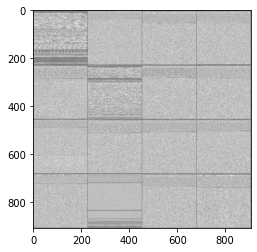

In [14]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [15]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  
                                                
print(model)

RuntimeError: ignored

In [16]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html
PATH = './results_Exp01/Exp01_10-Epoch.pth'

In [17]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='mean')  # changed reduction to 'mean' 
                                                                                  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    # plt.plot(train_loss / len(train_loader.dataset))
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
    torch.save(model.state_dict(), PATH)


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(16, 1, 224, 224)[:n]])
                save_image(comparison.cpu(),
                         './results_Exp01/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    # plt.plot(test_loss)
    Epoch_Loss['test_epoch'].append(epoch)
    Epoch_Loss['test_loss'].append(test_loss)

In [ ]:
epochs = 10


for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        # change liveloss to my model
        # https://github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
        # https://www.w3resource.com/graphics/matplotlib/basic/matplotlib-basic-exercise-5.php
        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./plot_Exp01/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()
    
        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)  # Change it (64, 100) to (16, 100)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),  # (64, 1, 224, 224) to (16, 1, 224, 224)
                       './results_Exp01/sample_' + str(epoch) + '.png')
        